In [1]:
import itertools
import json, sys

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
sys.path.append(r'./../snorkel')

import utils

## Task Overview

Given product search queries like 'apple watch series 3', our goal is to tag the entities with labels like 'MODELNAME', 'CATEGORY', etc.

Example: "apple watch series 3" -> "brand category modelname modelname"

## Dataset
In this tutorial, we use <a href="https://dataturks.com/projects/Mohan/Best%20Buy%20E-commerce%20NER%20dataset">BestBuy E-Commerce Dataset</a> from DataTurks. The dataset contains actual search queries on bestBuy.com manually labeled by human experts. Each word (token) is tagged with an entity. Note that not all entities are tagged correctly in this dataset. For this tutorial, we will make sure that the dev/test sets contain correct labels.

#### Data Preprocessing
There are 772 unique products and 1872 tagged entities in total. The original dataset has 7 labels (category, modelname, brand, storage, screen size, etc). If a token does not belong to one of these 7 categories, then it is not tagged. We preprocess the data by only keeping 3 labels **(CATEGORY, MODELNAME, OTHER)** from the label set. All other labels (including abstain) are mapped to **OTHER**. Thus, this is a 4-class prediction problem.

### Load BestBuy Dataset

In [2]:
with open('train_data.json') as f:
    train_data = json.loads(f.read())

with open('dev_data.json') as f:
    dev_data = json.loads(f.read())

with open('test_data.json') as f:
    test_data = json.loads(f.read())
    
print('Number of products in train set:', len(train_data))
print('Number of products in dev set:', len(dev_data))
print('Number of products in test set:', len(test_data))

Number of products in train set: 554
Number of products in dev set: 135
Number of products in test set: 76


In this tutorial, we will assume that we don't have the labels for the training set. We have the ground truth labels for dev and test set. We will use the dev set to tune the label model, and evaluate on the test set.

In [3]:
CATEGORY = 0
MODELNAME = 1
BRAND = 2
OTHER = 3

## Part I: Label Model

To begin with, we will use Snorkel's Label Model to generate training labels for each token in the product names.

### Prepare dataframe for labeling functions

We construct a dataframe where each row is a token that want to predict. The columns are:
* 'Product Name': the product name that the token appears in.
* 'word_idx': the index of the token in the product name.
* 'label': the entity label of the token.

For instance, the entry for 'apple watch' in the original dataset will be represented with the first 2 rows in this dataframe.


In [4]:
train_df = utils.preprocess_data(train_data)
X_train, y_train = train_df[['product_name', 'word_idx']], train_df['label']

dev_df = utils.preprocess_data(dev_data)
X_dev, y_dev = dev_df[['product_name', 'word_idx']], dev_df['label']

test_df = utils.preprocess_data(test_data)
X_test, y_test = test_df[['product_name', 'word_idx']], test_df['label']

X_train.shape, X_dev.shape, X_test.shape

((1349, 2), (335, 2), (199, 2))

In [5]:
train_df.head()

,product_name,word_idx,label
0,fingerlings baby monkeys,0,2
1,fingerlings baby monkeys,1,3
2,fingerlings baby monkeys,2,3
3,b&w 685 s2,0,2
4,b&w 685 s2,1,1


### Class distributions in dev/test data split

Text(0, 0.5, 'Count')

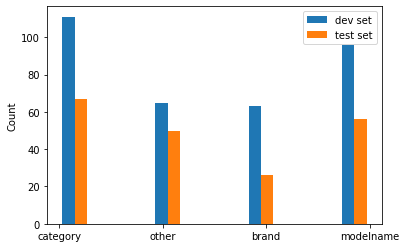

In [6]:
plt.hist([y_dev.map(lambda i: utils.label_list[i]), y_test.map(lambda i: utils.label_list[i])])
plt.legend(['dev set', 'test set'])
plt.ylabel('Count')

### Write Labeling Functions

We can write labeling functions using the following rules.
1. Heuristics.
    - if the token is before a number, then it is likely MODELNAME. E.g. "apple watch *series* 3"
    - if the token contains a number, then it is likely MODELNAME. E.g. "apple watch series *3*"
    - if the token contains some measurement units (e.g. tb, inch), then it is probably OTHER.
2. External knowledge source (a list of brand names scrapped from BestBuy)
    - if the token is in the list of brand names or list of categories, then it is BRANDNAME/CATEGORY.
    - if the token is after a brand name, it is likely MODELNAME. E.g. beats *solo3* wireless

Here an example of a labeling function that checks if the token contains a number:

In [7]:
from snorkel.labeling import labeling_function
@labeling_function()
def lf_has_numbers(x):
    w = x.feature[1]
    if any(i.isdigit() for i in w):
        return MODELNAME
    return -1

We implement other LFs in labeling_functions and will import from there.

In [8]:
import labeling_functions as lf

### Apply the LFs to all data points

In [9]:
from snorkel.labeling import PandasLFApplier
from snorkel.labeling import LFAnalysis

lfs = [lf.lf_has_numbers,
       lf.lf_is_noun,
       lf.lf_is_single_word,
       lf.lf_is_before_num, 
       lf.lf_is_other,
       lf.lf_is_brand, 
       lf.lf_is_in_category_list]

applier = PandasLFApplier(lfs=lfs)

L_train = applier.apply(df=X_train)
L_dev = applier.apply(df=X_dev)
L_test = applier.apply(df=X_test)

C:\Users\zhenz\Anaconda3\envs\keras\lib\site-packages\tqdm\std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:02<00:00, 82.87it/s]


### Evaluate the LFs on the dev set

In [10]:
LFAnalysis(L=L_dev, lfs=lfs).lf_summary(y_dev.values)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
lf_has_numbers,0,[1],0.161194,0.038806,0.008955,41,13,0.759259
lf_is_noun,1,[0],0.364179,0.211940,0.047761,74,48,0.606557
lf_is_single_word,2,[1],0.047761,0.047761,0.017910,10,6,0.625000
lf_is_before_num,3,[1],0.053731,0.023881,0.023881,15,3,0.833333
lf_is_other,4,[3],0.032836,0.011940,0.011940,8,3,0.727273
lf_is_brand,5,[2],0.107463,0.005970,0.005970,35,1,0.972222
lf_is_in_category_list,6,[0],0.220896,0.167164,0.002985,66,8,0.891892


In [11]:
# total coverage
((L_dev != -1).sum(1) > 0).sum() / len(L_dev)

0.7343283582089553

### Train a Label Model

In [12]:
from snorkel.labeling import LabelModel
from snorkel.labeling import MajorityLabelVoter

majority_model = MajorityLabelVoter(cardinality=4)
preds_train = majority_model.predict(L=L_train)

majority_acc = majority_model.score(L=L_dev, Y=y_dev)["accuracy"]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

Majority Vote Accuracy:   76.1%


In [13]:
label_model = LabelModel(cardinality=4, verbose=True)
label_model.fit(L_train=L_train, n_epochs=3000, lr=1e-5)#, class_balance=[0.3, 0.3, 0.2, 0.2])

label_model_acc = label_model.score(L=L_dev, Y=y_dev)["accuracy"]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Label Model Accuracy:     72.4%


In [14]:
confusion_matrix(label_model.predict(L=L_dev), y_dev)

array([[ 0, 21, 28, 16, 24],
       [ 0, 88, 16, 10, 24],
       [ 0,  1, 50,  1, 12],
       [ 0,  0,  1, 35,  0],
       [ 0,  1,  1,  1,  5]], dtype=int64)

#### Use the labels with highest soft probabilities as the training labels

In [15]:
train_labels = label_model.predict_proba(L_train).argmax(axis=1)
X_train['label'] = train_labels
X_train.head()

,product_name,word_idx,label
0,fingerlings baby monkeys,0,0
1,fingerlings baby monkeys,1,0
2,fingerlings baby monkeys,2,0
3,b&w 685 s2,0,1
4,b&w 685 s2,1,1


Some of the products are still hard to predict. For example, movie and game names: circle by disney, call of duty, bioshock the collection, etc. 
In practice we can use use a database of movie names or game names to write LFs for these products.

## Part II: Train an End Model

### Build dataframe for seq2seq entity recognition task

In [16]:
train_seq_df = utils.build_seq_tag_df(X_train)
dev_seq_df = utils.build_seq_tag_df(dev_df)
test_seq_df = utils.build_seq_tag_df(test_df)

train_seq_df.head()

,product,label
0,fingerlings baby monkeys,category category category
1,b&w 685 s2,modelname modelname modelname
2,aw17r4,modelname
3,android tv box,category category category
4,xbox one,category category


In [17]:
import end_model
from sklearn.metrics import accuracy_score, classification_report

y_test_true, pred = end_model.train_end_model(train_seq_df, dev_seq_df, test_seq_df, n_epochs=8)
true_flatten = np.array(y_test_true).flatten()
pred_flatten = np.array(pred).flatten()

report = classification_report(pred_flatten, true_flatten, labels=['brand', 'category', 'modelname'])
print(report)
accuracy_score(true_flatten[np.logical_and(true_flatten!='PAD', true_flatten!='other')],
               pred_flatten[np.logical_and(true_flatten!='PAD', true_flatten!='other')])

Using TensorFlow backend.




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
C:\Users\zhenz\Anaconda3\envs\keras\lib\site-packages\keras_contrib\layers\crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
C:\Users\zhenz\Anaconda3\envs\keras\lib\site-packages\keras_contrib\layers\crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '




Train on 554 samples, validate on 135 samples
Epoch 1/8
 - 3s - loss: 5.9077 - crf_viterbi_accuracy: 0.3415 - val_loss: 5.4952 - val_crf_viterbi_accuracy: 0.2475
Epoch 2/8
 - 0s - loss: 5.2511 - crf_viterbi_accuracy: 0.6781 - val_loss: 5.8880 - val_crf_viterbi_accuracy: 0.3302
Epoch 3/8
 - 1s - loss: 4.9684 - crf_viterbi_accuracy: 0.7232 - val_loss: 5.7856 - val_crf_viterbi_accuracy: 0.3302
Epoch 4/8
 - 1s - loss: 4.8182 - crf_viterbi_accuracy: 0.7336 - val_loss: 5.8668 - val_crf_viterbi_accuracy: 0.3758
Epoch 5/8
 - 1s - loss: 4.6660 - crf_viterbi_accuracy: 0.8113 - val_loss: 5.9538 - val_crf_viterbi_accuracy: 0.4748
Epoch 6/8
 - 1s - loss: 4.5086 - crf_viterbi_accuracy: 0.9061 - val_loss: 6.2560 - val_crf_viterbi_accuracy: 0.5048
Epoch 7/8
 - 1s - loss: 4.3846 - crf_viterbi_accuracy: 0.9424 - val_loss: 6.6316 - val_crf_viterbi_accuracy: 0.5277
Epoch 8/8
 - 1s - loss: 4.3071 - crf_viterbi_accuracy: 0.9637 - val_loss: 6.9311 - val_crf_viterbi_accuracy: 0.5304
              precision   

0.7046979865771812

In [18]:
X_train['gt_label'] = y_train
train_seq_df_gt = utils.build_seq_tag_df(X_train, 'gt_label')

# train with 'gt' labels
y_test_true, pred2 = end_model.train_end_model(train_seq_df_gt, dev_seq_df, test_seq_df, n_epochs=8)
true_flatten = np.array(y_test_true).flatten()
pred2_flatten = np.array(pred2).flatten()

report2 = classification_report(pred2_flatten, true_flatten, labels=['brand', 'category', 'modelname'])
print(report2)
accuracy_score(true_flatten[np.logical_and(true_flatten!='PAD', true_flatten!='other')],
               pred2_flatten[np.logical_and(true_flatten!='PAD', true_flatten!='other')])

C:\Users\zhenz\Anaconda3\envs\keras\lib\site-packages\keras_contrib\layers\crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
C:\Users\zhenz\Anaconda3\envs\keras\lib\site-packages\keras_contrib\layers\crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Train on 554 samples, validate on 135 samples
Epoch 1/8
 - 3s - loss: 5.8183 - crf_viterbi_accuracy: 0.1644 - val_loss: 5.4950 - val_crf_viterbi_accuracy: 0.1906
Epoch 2/8
 - 0s - loss: 5.6472 - crf_viterbi_accuracy: 0.2955 - val_loss: 5.2662 - val_crf_viterbi_accuracy: 0.3302
Epoch 3/8
 - 1s - loss: 5.3826 - crf_viterbi_accuracy: 0.4497 - val_loss: 5.0543 - val_crf_viterbi_accuracy: 0.5206
Epoch 4/8
 - 1s - loss: 5.1052 - crf_viterbi_accuracy: 0.6526 - val_loss: 4.8653 - val_crf_viterbi_accuracy: 0.5853
Epoch 5/8
 - 1s - loss: 4.8691 - crf_viterbi_accuracy: 0.7051 - val_loss: 4.7818 - val_crf_viterbi_accuracy: 0.6153
Epoch 6/8
 - 1s - loss: 4.7341 - crf_viterbi_accuracy: 0.7467 - val_loss: 4.7547 - val_crf_viterbi_accuracy: 0.6355
Epoch 7/8
 - 1s - loss: 4.6441 - crf_viterbi_accuracy: 0.7995 - val_loss: 4.7642 - val_crf_viterbi_accuracy: 0.6485
Epoch 8/8
 - 1s - loss: 4.5678 - crf_viterbi_accuracy: 0.8392 - val_loss: 4.7868 - val_crf_viterbi_accuracy: 0.6638
              precision   

0.7114093959731543

In [19]:
# train_seq_df.to_pickle("./train_seq_df.pkl")
# dev_seq_df.to_pickle("./dev_seq_df.pkl")
# test_seq_df.to_pickle("./test_seq_df.pkl")

# # save gt labels for comparison
# X_train['gt_label'] = y_train
# train_seq_df_gt = utils.build_seq_tag_df(X_train, 'gt_label')
# train_seq_df_gt.to_pickle("./train_seq_df_gt.pkl")

In [20]:
# X_train['gt_label'] = y_train
# X_train.to_pickle("./train_per_token_df.pkl")
# dev_df.to_pickle("./dev_per_token_df.pkl")
# test_df.to_pickle("./test_per_token_df.pkl")